In [6]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import optax
import numpy as np
from matplotlib import pyplot as plt

In [7]:
key = jax.random.PRNGKey(2)

In [8]:
#
# The potential energy function depending on the coordinates
#
def potential(x):
    return -jnp.sqrt(2)/jnp.sqrt(jnp.sum(x**2, axis = -1))


# the hamiltonian
H = module.hamiltonians.Particles(masses = [1], potential = potential, d_space = 3)

The wavefunction is parametrised with a bounded nerual network and a decaying gaussian envelope to ensure normalisability.

$$
\log{\Psi} = a \cdot \mathrm{sigmoid}(\mathrm{NN}(\vec{r})) - \frac{r^2}{b^2}
$$

The coefficients $a$ and $b$ have to be chosen or could be trained.

In [9]:
def sigmoid(x):
    return 1/(1 + jnp.exp(-x))

In [10]:
class Orbital(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__((3,))

        self.h = jax.vmap(self.calc_logpsi_single, in_axes=[None, 0])

    def init_parameters(self, key):
        keys = jax.random.split(key, 5)

        return {"a": jax.random.normal(keys[0], shape = (128, 3)),
                "b": jax.random.normal(keys[1], shape = (1, 128)),
                "c": jax.random.normal(keys[2], shape = (128,)),
                "d": jax.random.normal(keys[3], shape = (1,)),
                "scale": jnp.array(2.)}
    
    def calc_logpsi_single(self, parameters, x):
        r = jnp.sqrt(jnp.sum(x**2))    # shift to a non-centered envelope

        x = parameters["a"] @ x
        x = x + parameters["c"]
        x = sigmoid(x)
        x = parameters["b"] @ x
        x = x + parameters["d"]
        x = sigmoid(x)

        return jnp.squeeze(x * parameters["scale"] - r**2/5**2)
    
    def calc_logpsi(self, parameters, x):

        return self.h(parameters, x)

In [11]:
wavefun = Orbital()
parameters = wavefun.init_parameters(key)

## Inspect the Wavefunction

We take straight lines through the origin at radom angles and plot the wavefunction along it.

Text(0.5, 1.0, 'Radial Wavefunction')

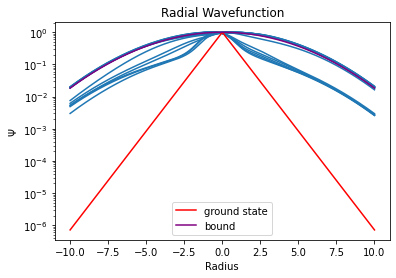

In [12]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

getLine = jax.vmap(getLine, in_axes=[0,0])

phi = jax.random.uniform(key, shape = (15,)) * 2 * jnp.pi
theta = jax.random.uniform(key, shape = (15,)) * jnp.pi

r, line = getLine(phi,theta)

for i in range(15):
    prob = wavefun.calc_logpsi(parameters, line[i])
    plt.plot(r[i], jnp.exp(prob)/jnp.max(jnp.exp(prob)), color = "C0")


s = np.linspace(-10,10, num = 500)
plt.plot(s, jnp.exp(-jnp.abs(s)*jnp.sqrt(2)), color = "red", label = "ground state")
plt.plot(s, jnp.exp(-s**2/5**2), color = "purple", label = "bound")

plt.yscale("log")

plt.legend()

plt.xlabel("Radius")
plt.ylabel("$\\Psi$")

plt.title("Radial Wavefunction")


## Initialise a MC-Sampler

In [13]:
sampler = module.samplers.MCMC(wavefun, variance = 0.6)

In [43]:
N = 50000
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), N)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc)/jnp.sqrt(N))
print("Energy Error in units of MC deviation:", jnp.abs(jnp.mean(H_loc) + 1)/jnp.std(H_loc)*jnp.sqrt(N))

Acceptance Ratio: 0.41963997
Expected Energy: -0.91527045
Std of Expected Energy: 0.0039766915
Energy Error in units of MC deviation: 21.306545


### Figure out the decorrelation-time

(0.0, 50.0)

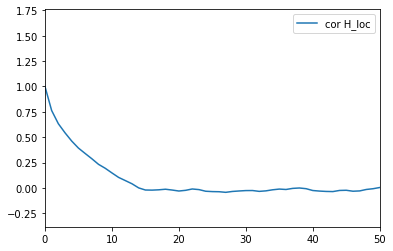

In [44]:
plt.plot(jnp.correlate(H_loc-jnp.mean(H_loc), H_loc[0:2000])/jnp.std(H_loc[0:2000])**2/2000, label = "cor H_loc")
plt.legend()
plt.xlim(0,50)

In [16]:
## subsample by factor 10

ss_factor = 15

subsamples = samples[0:-1:ss_factor]

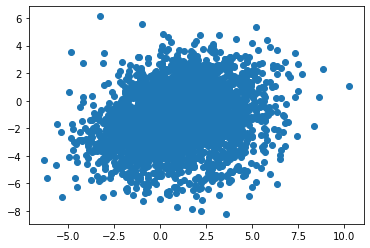

In [17]:
plt.scatter(subsamples[:, 0], subsamples[:, 1])

To estimate the gradient of the expected energy via the formula:

$$
\nabla \left< E \right>  = 2\,\Re\, \mathbb{E}\{\nabla \log \Psi [H_{\mathrm{loc}}(r) - \mathbb{E}(E)]\}
$$

we implement a help function:

In [18]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc)
    dE = jnp.std(E_loc)
    grad_log = orbital.grad_logpsi(parameters, samples)

    return jax.tree_util.tree_map(lambda tree: 2*jnp.real(jnp.mean(jnp.swapaxes(jnp.swapaxes(tree, 0, -1) * (E_loc - E), 0, -1), axis = 0)), grad_log), E, dE

The energy can now be optimised:

In [19]:
Es_ = []
dEs_ = []
ratios_ = []

In [31]:
N = 4000

# define
optimizer = optax.adam(learning_rate=0.01)

# initialise
optimizer_state = optimizer.init(parameters)

for i in tqdm(range(50)):
    key, _ = jax.random.split(key)
    samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), N*ss_factor)
    samples = samples[0:-1:ss_factor]
    grad, E, dE = calc_grad_E(H, wavefun, parameters, samples)

    Es_.append(E)
    dEs_.append(dE)
    ratios_.append(ratio)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, parameters)

    parameters = optax.apply_updates(parameters, updates)

Es = np.array(Es_)
dEs = np.array(dEs_) / np.sqrt(N)
ratios = np.array(ratios_)

100%|██████████| 50/50 [00:07<00:00,  6.67it/s]


Text(0.5, 1.0, 'Energy Optimisation')

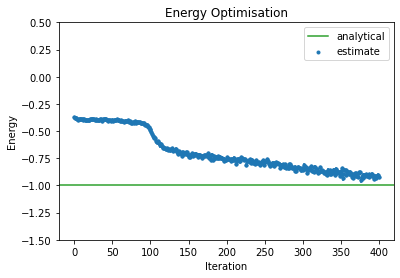

In [32]:
index = np.arange(Es.shape[0])

plt.scatter(index, Es, label = "estimate", marker = ".")
# plt.fill_between(index, Es - dEs, Es + dEs, alpha = 0.7, label = "$\\pm \\sigma$", color = "C3")
plt.errorbar(index, Es, yerr = dEs, fmt = ".")
plt.ylim(-1.5,0.5)
# plt.xlim(200,300)
plt.axhline(-1, color = "C2", label = "analytical")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Energy Optimisation")

Text(0.5, 1.0, 'Energy Optimisation')

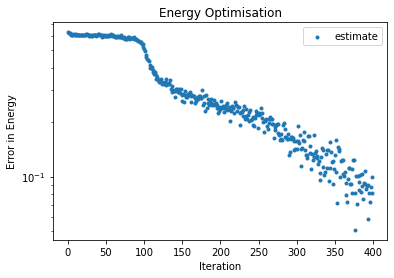

In [33]:
index = np.arange(Es.shape[0])

# plt.errorbar(index, np.abs(Es + 1), yerr = dEs, label = "estimate", fmt = ".")
plt.scatter(index, np.abs(Es + 1), label = "estimate", marker = ".")
# plt.fill_between(index, Es - dEs, Es + dEs, alpha = 0.4, label = "$\\pm \\sigma$")
# plt.ylim(-2,2)
# plt.axhline(-1, color = "C2", label = "analytical")
plt.yscale("log")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Error in Energy")
plt.title("Energy Optimisation")

Now, the variance of the expected energy has decreased, as expected for correct eigenstate:

In [39]:
N = 10000
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), N*ss_factor)
samples = samples[0:-1:ss_factor]
V_loc = H.calc_V_loc(wavefun, parameters, samples)
T_loc = H.calc_T_loc(wavefun, parameters, samples)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc)/jnp.sqrt(N))
print("Energy Error in units of MC deviation:", jnp.abs(jnp.mean(H_loc) + 1)/jnp.std(H_loc)*jnp.sqrt(N))

Acceptance Ratio: 0.42138
Expected Energy: -0.9213747
Std of Expected Energy: 0.00997471
Energy Error in units of MC deviation: 7.882467


Text(0.5, 1.0, 'Radial Wavefunction')

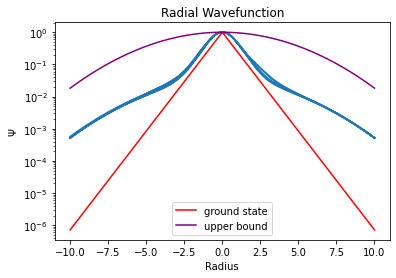

In [40]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

getLine = jax.vmap(getLine, in_axes=[0,0])

phi = jax.random.uniform(key, shape = (15,)) * 2 * jnp.pi
theta = jax.random.uniform(key, shape = (15,)) * jnp.pi

r, line = getLine(phi,theta)

for i in range(15):
    prob = wavefun.calc_logpsi(parameters, line[i])
    plt.plot(r[i], jnp.exp(prob)/jnp.max(jnp.exp(prob)), color = "C0")


s = np.linspace(-10,10, num = 500)
plt.plot(s, jnp.exp(-jnp.abs(s)*jnp.sqrt(2)), color = "red", label = "ground state")
plt.plot(s, jnp.exp(-s**2/5**2), color = "purple", label = "upper bound")

plt.yscale("log")

plt.legend()

plt.xlabel("Radius")
plt.ylabel("$\\Psi$")

plt.title("Radial Wavefunction")


In [41]:
parameters["scale"]

Array(3.9863887, dtype=float32)

---